In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder

In [16]:
df = pd.read_csv("student-data.csv")

In [ ]:
num_features = df.shape[1]
num_records = df.shape[0]

print(f'Colunas: {num_features}')
print(f'Linhas: {num_records}')

Colunas: 31
Linhas: 395


In [17]:
df.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
passed        object
dtype: object

In [18]:
df.isnull().sum()


school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
passed        0
dtype: int64

O dataset não apresenta valores nulos, o que simplifica o processo de pré-processamento. Todas as colunas estão completas.


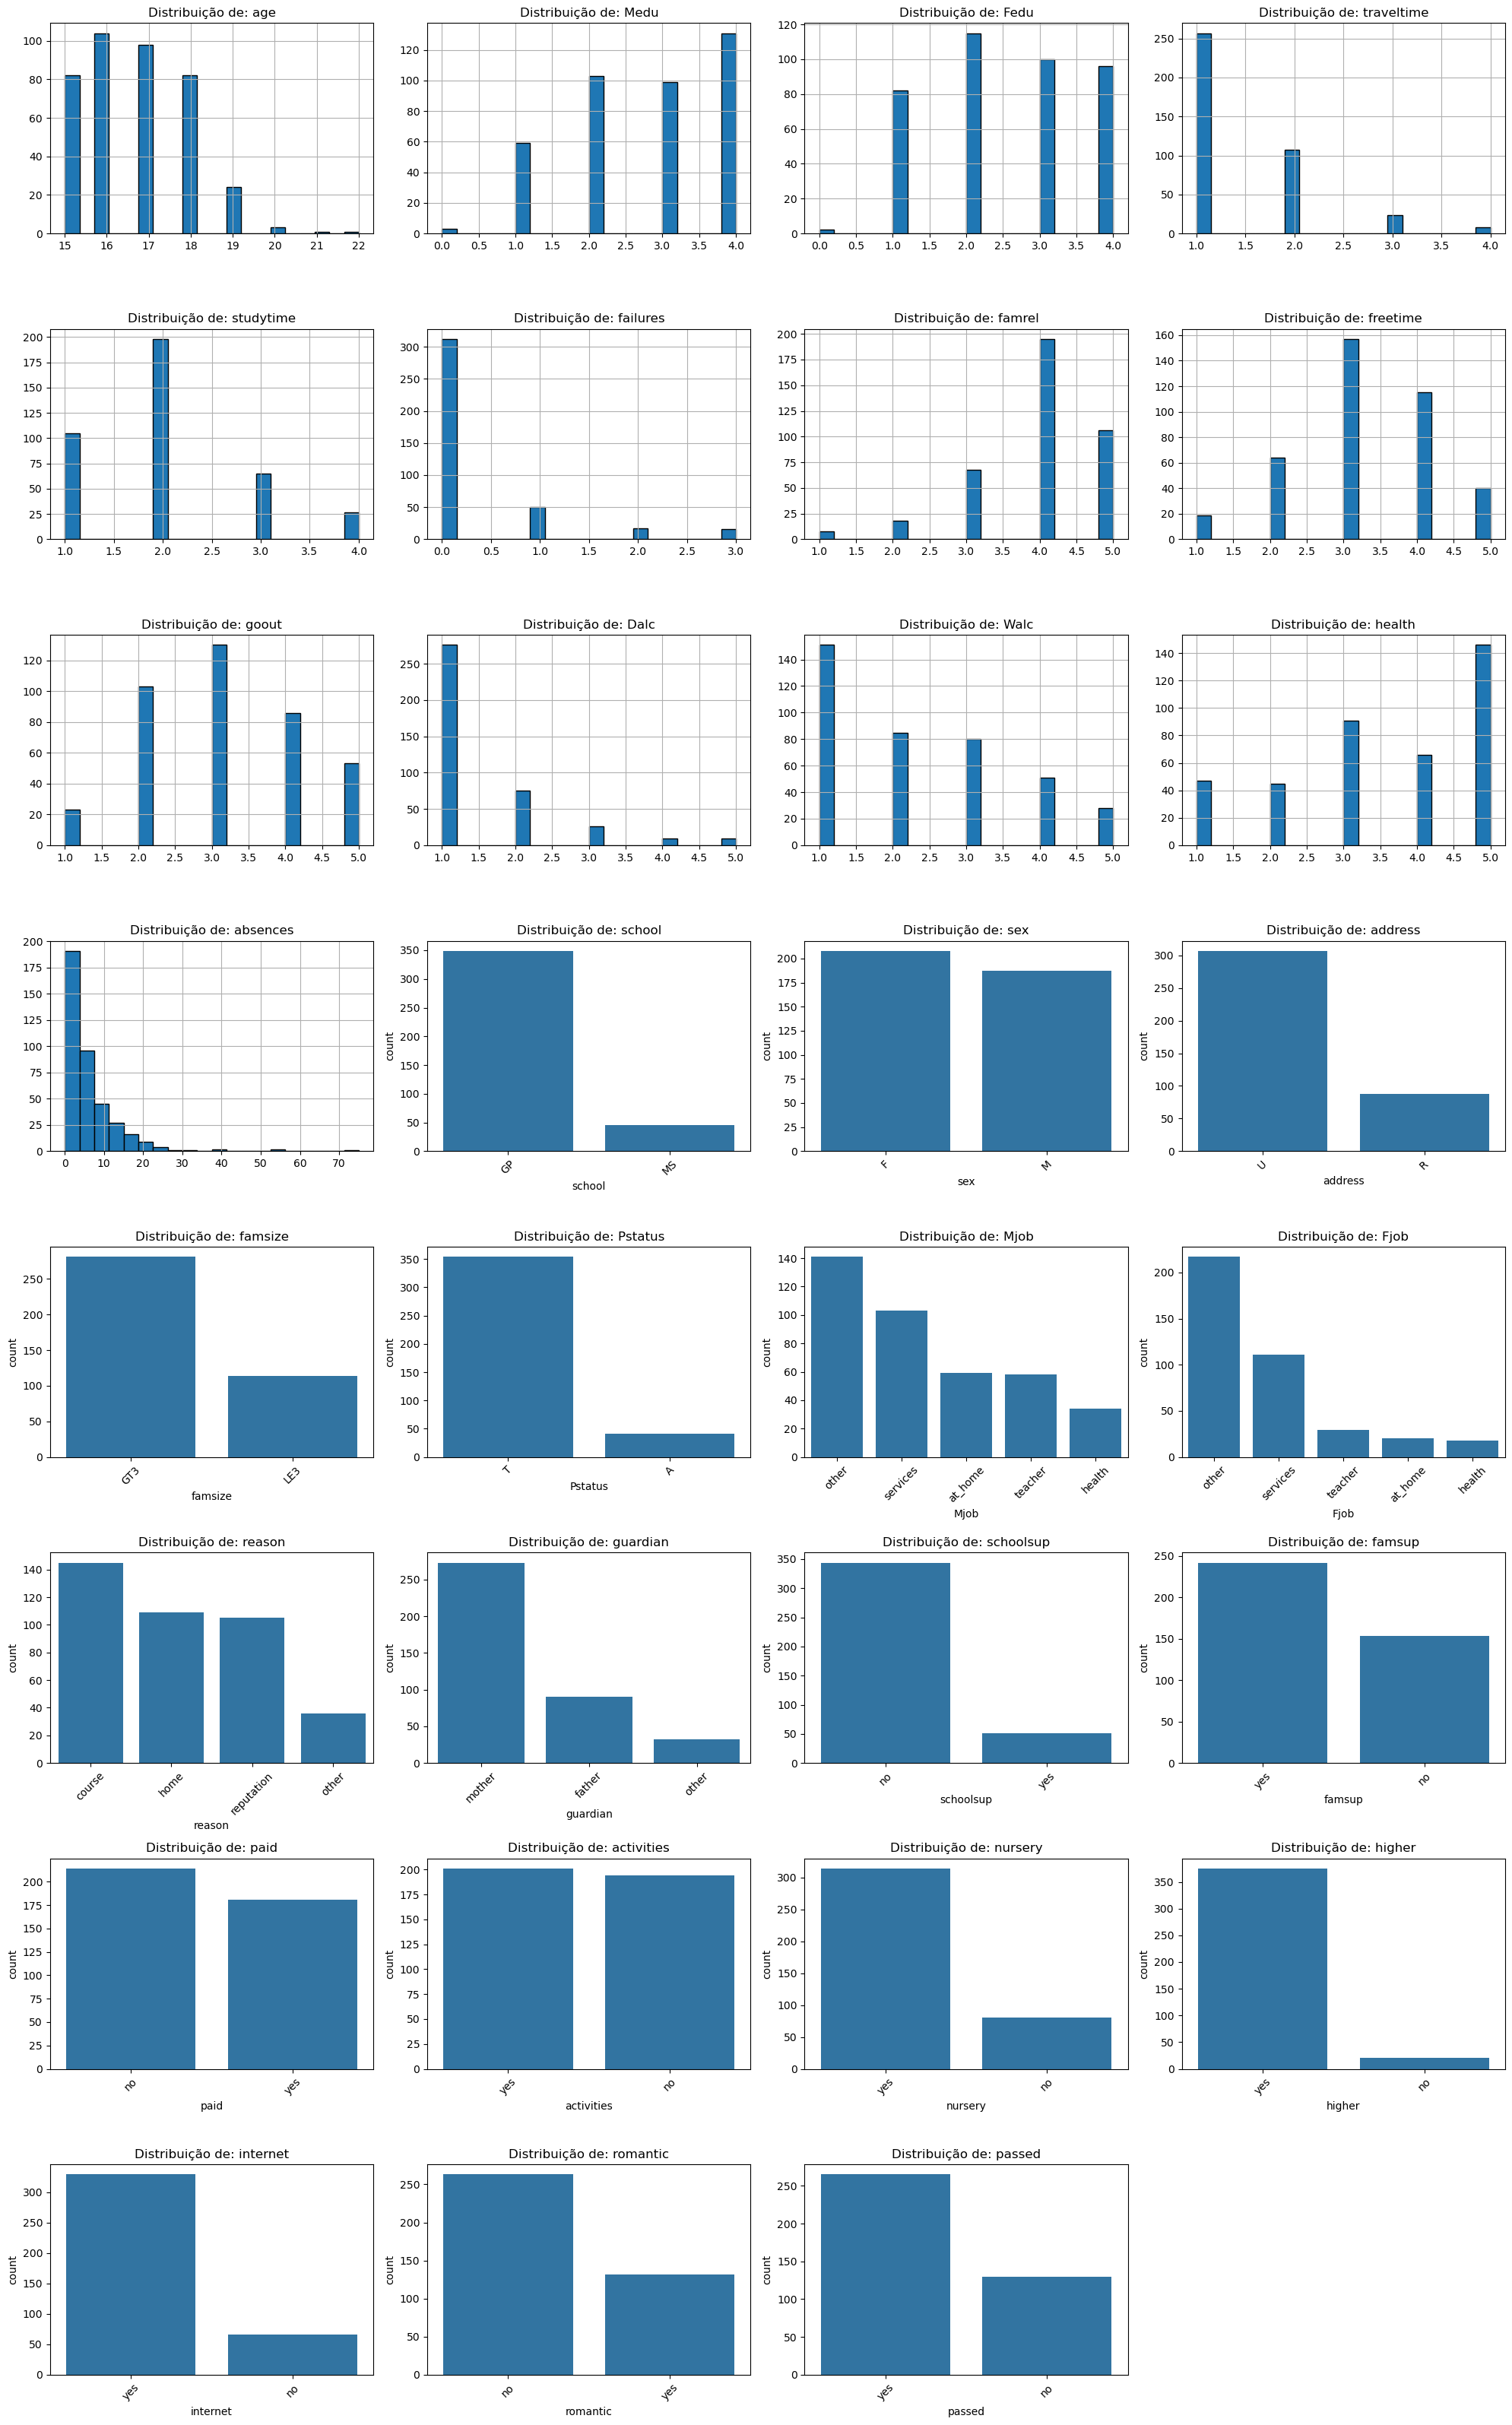

In [39]:
# Calcular o número de features e records
num_features = df.shape[1]
num_records = df.shape[0]

# Identificar colunas numéricas e categóricas com baixa cardinalidade
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
low_card_cols = [col for col in df.columns if df[col].nunique() < 10 and df[col].dtype == 'object']  # Seleciona apenas colunas object

# Calcular o número total de gráficos necessários
total_plots = len(numeric_cols) + len(low_card_cols)

# Definir o número de colunas e linhas para os subplots
cols_per_row = 4
rows = math.ceil(total_plots / cols_per_row)

# Criar os subplots
fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 4))
axes = axes.flatten()
plot_index = 0

# Plotar histogramas para colunas numéricas
for i, col in enumerate(numeric_cols):
    if plot_index < total_plots:  # Garante que não exceda o número de subplots
        df[col].hist(bins=20, ax=axes[plot_index], edgecolor='black')
        axes[plot_index].set_title(f'Distribuição de: {col}')
        plot_index += 1

# Plotar gráficos de contagem para colunas categóricas com baixa cardinalidade
for i, col in enumerate(low_card_cols):
    if plot_index < total_plots:
        sns.countplot(data=df, x=col, ax=axes[plot_index], order=df[col].value_counts().index)
        axes[plot_index].set_title(f'Distribuição de: {col}')
        axes[plot_index].tick_params(axis='x', rotation=45)
        plot_index += 1

# Apagar subplots extras se não forem usados
for j in range(plot_index, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Outliers em colunas numéricas (método IQR) ###



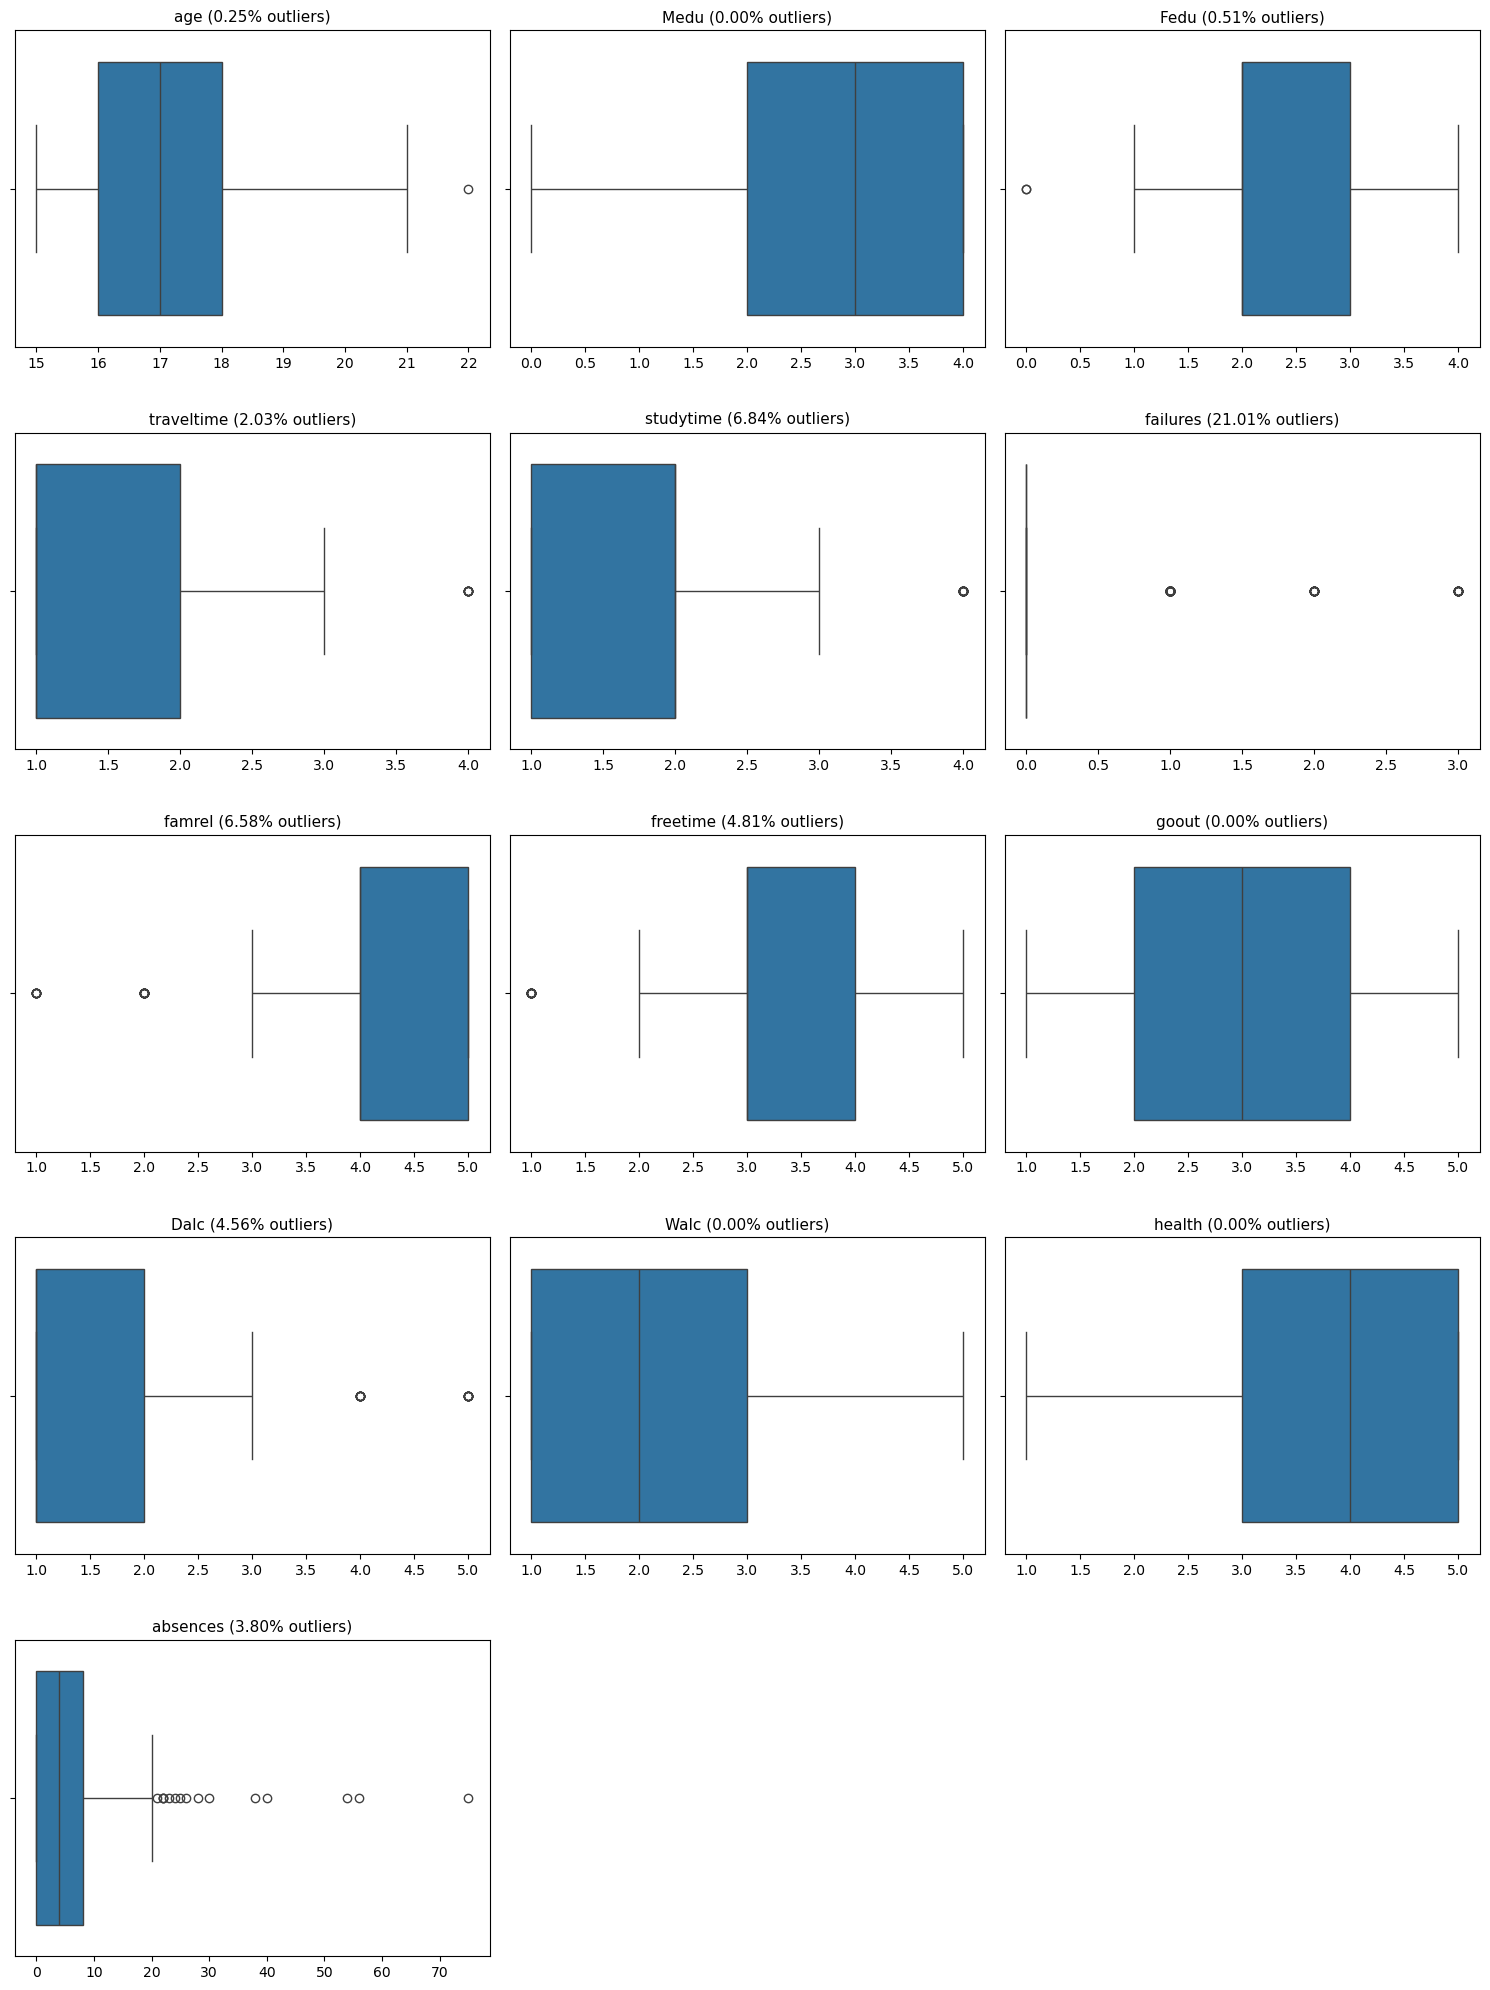

In [ ]:
# Colunas numéricas
numeric_cols = df.select_dtypes(include='number').columns.tolist()

n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    percent = (len(outliers) / len(df)) * 100

    sns.boxplot(x=df[col], ax=axes[idx])
    axes[idx].set_title(f"{col} ({percent:.2f}% outliers)", fontsize=11)
    axes[idx].set_xlabel("")
    
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(h_pad=3.0)
plt.show()

In [30]:
# Selecionar apenas colunas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Dicionário para guardar os outliers extremos por coluna
extreme_outliers = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Filtrar os valores que são outliers extremos
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    
    if not outliers.empty:
        extreme_outliers[col] = outliers

# Mostrar resultados
for col, values in extreme_outliers.items():
    print(f"\nOutliers extremos na variável '{col}':")
    print(values.sort_values().values)



Outliers extremos na variável 'failures':
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3]

Outliers extremos na variável 'absences':
[38 40 54 56 75]


A seguir decidimos analisar a correlação entre as colunas e chegámos à conclusão que Medu e Fedu eram semelhantes, o que faz sentido pois são categorias quase iguais o que muda é o progenitor. Dalc e Walc também são semelhantes pois avaliam a mesma coisa e só difere o intervalo de tempo.

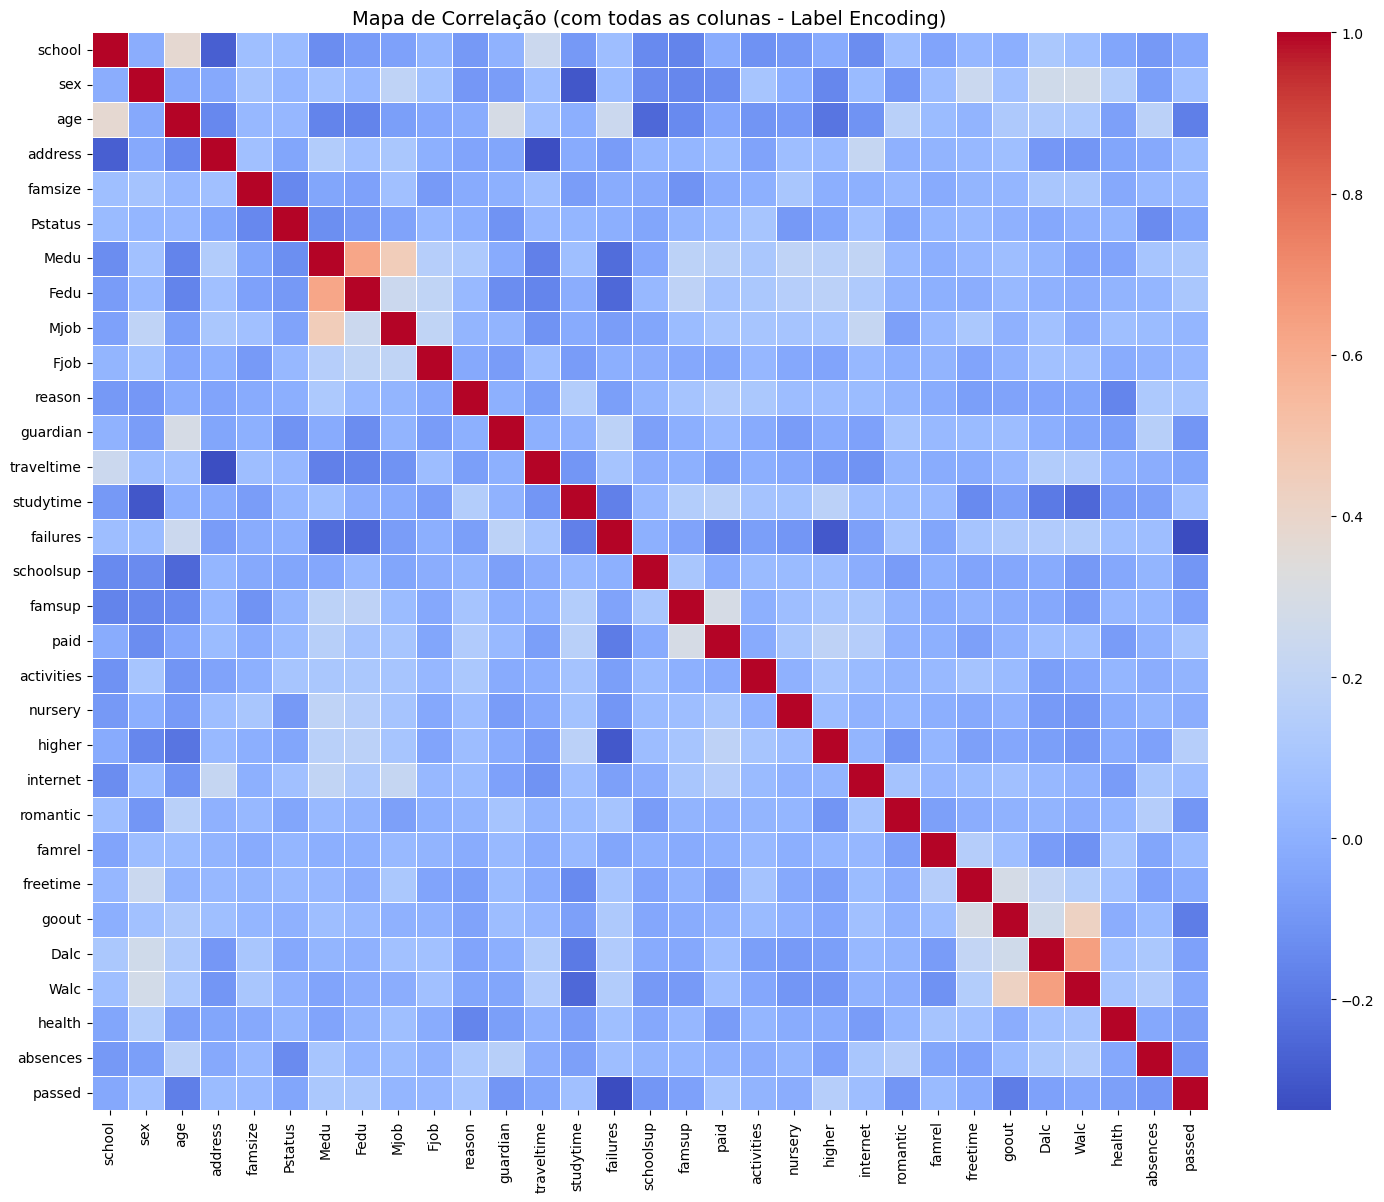

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Copiar o DataFrame original
df_temp = df.copy()

# Aplicar Label Encoding temporário às colunas categóricas
label_encoder = LabelEncoder()
for col in df_temp.select_dtypes(include='object').columns:
    df_temp[col] = label_encoder.fit_transform(df_temp[col])

# Calcular a matriz de correlação
corr_matrix = df_temp.corr()

# Plotar o heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Mapa de Correlação (com todas as colunas - Label Encoding)", fontsize=14)
plt.show()

In [24]:
df.select_dtypes(include='object').nunique()


school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
passed        2
dtype: int64

A maioria das variáveis categóricas possui baixa cardinalidade, sendo adequadas para codificação com One-Hot Encoding sem causar aumento significativo da dimensionalidade.


In [35]:
from sklearn.model_selection import train_test_split

# Separar os dados em features (X) e variável alvo (y)
X = df.drop('passed', axis=1)  # Todas as colunas exceto 'passed'
y = df['passed']

# Dividir os dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Tamanho do conjunto de treino: {len(X_train)}')
print(f'Tamanho do conjunto de teste: {len(X_test)}')

Tamanho do conjunto de treino: 316
Tamanho do conjunto de teste: 79
